In [4]:
from ultralytics.utils.loss import v8DetectionLoss
from ultralytics import YOLO
import torch


model = YOLO('yolov8n.pt') 

results = model(['coco8/images/train/000000000034.jpg'])[0]
results


0: 448x640 1 zebra, 4.1ms
Speed: 0.6ms preprocess, 4.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

In [6]:
results.plot()

array([[[  5, 132,  87],
        [  2, 128,  86],
        [ 11, 137,  95],
        ...,
        [  0,  91,  73],
        [ 32, 131, 113],
        [  8, 107,  89]],

       [[ 20, 146, 104],
        [  9, 135,  93],
        [ 11, 135,  93],
        ...,
        [ 16, 116,  98],
        [ 45, 145, 127],
        [ 34, 134, 116]],

       [[ 16, 142, 100],
        [  2, 126,  84],
        [  0, 121,  81],
        ...,
        [ 37, 139, 121],
        [ 44, 146, 128],
        [ 46, 148, 130]],

       ...,

       [[ 40, 143, 136],
        [102, 205, 197],
        [ 41, 140, 132],
        ...,
        [ 76, 137, 139],
        [103, 160, 162],
        [ 20,  75,  78]],

       [[ 35, 137, 126],
        [ 64, 166, 155],
        [ 65, 162, 152],
        ...,
        [ 26,  84,  89],
        [198, 253, 255],
        [120, 172, 178]],

       [[  0,  93,  78],
        [ 21, 122, 107],
        [ 56, 154, 142],
        ...,
        [144, 198, 205],
        [186, 235, 243],
        [169, 216, 224]]

In [9]:
results.boxes.xywhn

tensor([[0.3489, 0.4935, 0.6979, 0.9115]], device='cuda:0')

In [11]:
results.boxes.cls

tensor([22.], device='cuda:0')

In [20]:
import torch

# Get predicted bounding box coordinates and class label
pred_box = results.boxes.xywhn
pred_class_id = results.boxes.cls

# Read ground truth data from the txt file
gt_file_path = "coco8/labels/train/000000000034.txt"
with open(gt_file_path, "r") as f:
    gt_data = f.read().strip().split("\n")

# Parse ground truth data
gt_boxes = []
gt_class_ids = []
for gt_line in gt_data:
    gt_class_id, gt_center_x, gt_center_y, gt_width, gt_height = map(float, gt_line.split())
    gt_boxes.append([gt_center_x, gt_center_y, gt_width, gt_height])
    gt_class_ids.append(gt_class_id)

gt_boxes = torch.tensor(gt_boxes, device=pred_box.device)
gt_class_ids = torch.tensor(gt_class_ids, device=pred_class_id.device)

# Calculate IoU between predicted and ground truth boxes
def calculate_iou(box1, box2):
    # Convert from xywh format to xyxy format
    box1_xyxy = torch.cat((box1[:, :2] - box1[:, 2:] / 2, box1[:, :2] + box1[:, 2:] / 2), dim=1)
    box2_xyxy = torch.cat((box2[:, :2] - box2[:, 2:] / 2, box2[:, :2] + box2[:, 2:] / 2), dim=1)
    
    # Calculate intersection coordinates
    inter_top_left = torch.max(box1_xyxy[:, :2], box2_xyxy[:, :2])
    inter_bottom_right = torch.min(box1_xyxy[:, 2:], box2_xyxy[:, 2:])
    
    # Calculate intersection area
    inter_area = torch.clamp(inter_bottom_right - inter_top_left, min=0.0).prod(dim=1)
    
    # Calculate union area
    box1_area = box1[:, 2] * box1[:, 3]
    box2_area = box2[:, 2] * box2[:, 3]
    union_area = box1_area + box2_area - inter_area
    
    # Calculate IoU
    iou = inter_area / union_area
    
    return iou

iou_threshold = 0.5
correct_predictions = 0
total_predictions = len(pred_box)

for i in range(len(pred_box)):
    iou = calculate_iou(pred_box[i].unsqueeze(0), gt_boxes)
    max_iou, max_iou_idx = torch.max(iou, dim=0)
    

tensor(0.9669, device='cuda:0')


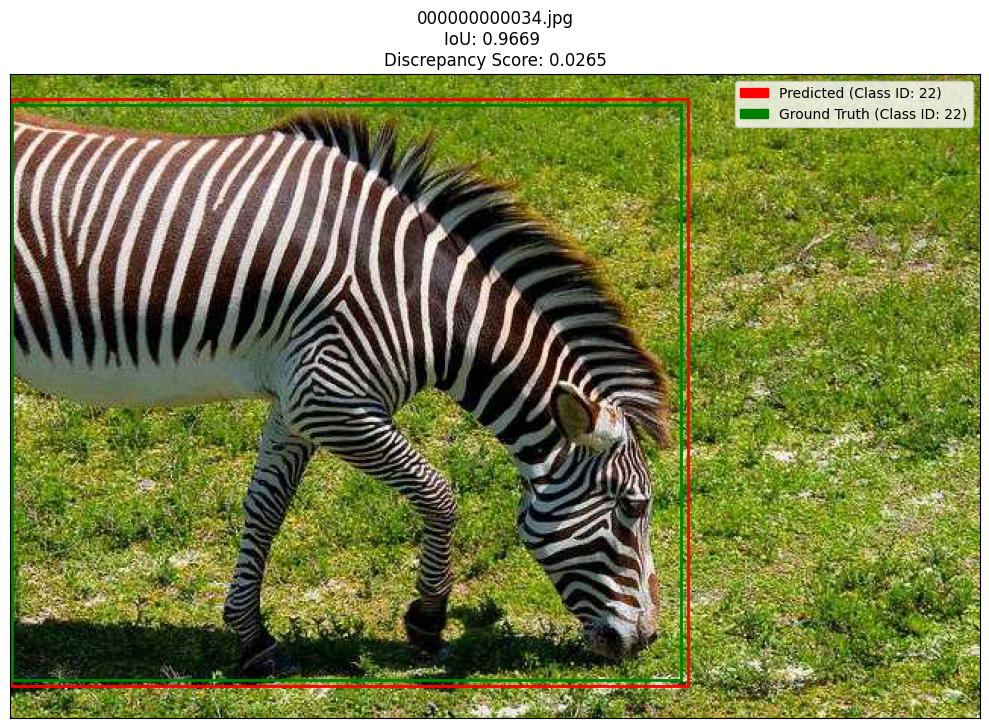

In [39]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Get predicted bounding box coordinates and class label
pred_box = results.boxes.xywhn
pred_class_id = results.boxes.cls

# Read ground truth data from the txt file
gt_file_path = "coco8/labels/train/000000000034.txt"
with open(gt_file_path, "r") as f:
    gt_data = f.read().strip().split("\n")

# Parse ground truth data
gt_boxes = []
gt_class_ids = []
for gt_line in gt_data:
    gt_class_id, gt_center_x, gt_center_y, gt_width, gt_height = map(float, gt_line.split())
    gt_boxes.append([gt_center_x, gt_center_y, gt_width, gt_height])
    gt_class_ids.append(gt_class_id)

gt_boxes = torch.tensor(gt_boxes, device=pred_box.device)
gt_class_ids = torch.tensor(gt_class_ids, device=pred_class_id.device)

# Calculate IoU between predicted and ground truth boxes
def calculate_iou(box1, box2):
    # Convert from xywh format to xyxy format
    box1_xyxy = torch.cat((box1[:, :2] - box1[:, 2:] / 2, box1[:, :2] + box1[:, 2:] / 2), dim=1)
    box2_xyxy = torch.cat((box2[:, :2] - box2[:, 2:] / 2, box2[:, :2] + box2[:, 2:] / 2), dim=1)
    
    # Calculate intersection coordinates
    inter_top_left = torch.max(box1_xyxy[:, :2], box2_xyxy[:, :2])
    inter_bottom_right = torch.min(box1_xyxy[:, 2:], box2_xyxy[:, 2:])
    
    # Calculate intersection area
    inter_area = torch.clamp(inter_bottom_right - inter_top_left, min=0.0).prod(dim=1)
    
    # Calculate union area
    box1_area = box1[:, 2] * box1[:, 3]
    box2_area = box2[:, 2] * box2[:, 3]
    union_area = box1_area + box2_area - inter_area
    
    # Calculate IoU
    iou = inter_area / union_area
    
    return iou

iou_values = calculate_iou(pred_box, gt_boxes)
max_iou, max_iou_idx = torch.max(iou_values, dim=0)

# Compare predicted class ID with ground truth class ID
if pred_class_id == gt_class_ids[max_iou_idx]:
    class_match = True
else:
    class_match = False

# Calculate discrepancy score
iou_weight = 0.8
class_weight = 0.2
iou_score = 1 - max_iou.item()
class_score = 0 if class_match else 1
discrepancy_score = iou_weight * iou_score + class_weight * class_score

# Load the image
image_path = "coco8/images/train/000000000034.jpg"
image = Image.open(image_path)

# Create a figure and axis
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Plot predicted bounding boxes
pred_patches = []
for box in pred_box:
    x, y, w, h = box.tolist()
    x1, y1 = x - w / 2, y - h / 2
    x2, y2 = x + w / 2, y + h / 2
    rect = patches.Rectangle((x1 * image.width, y1 * image.height), w * image.width, h * image.height,
                             linewidth=2, edgecolor='r', facecolor='none')
    pred_patches.append(rect)
    ax.add_patch(rect)

# Plot ground truth bounding boxes
gt_patches = []
for box in gt_boxes:
    x, y, w, h = box.tolist()
    x1, y1 = x - w / 2, y - h / 2
    x2, y2 = x + w / 2, y + h / 2
    rect = patches.Rectangle((x1 * image.width, y1 * image.height), w * image.width, h * image.height,
                             linewidth=2, edgecolor='g', facecolor='none')
    gt_patches.append(rect)
    ax.add_patch(rect)

# Set the figure title with the image filename, IoU value, class match, and discrepancy score
image_filename = os.path.basename(image_path)
title = f"{image_filename}\nIoU: {max_iou.item():.4f} \nDiscrepancy Score: {discrepancy_score:.4f}"
ax.set_title(title)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add legend with class IDs
pred_label = f"Predicted (Class ID: {int(pred_class_id.item())})"
gt_label = f"Ground Truth (Class ID: {int(gt_class_ids[max_iou_idx].item())})"
pred_patch = patches.Patch(color='r', label=pred_label)
gt_patch = patches.Patch(color='g', label=gt_label)
ax.legend(handles=[pred_patch, gt_patch], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()